In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

=================================================================================================================
# Lecture Notes: Kernelized Support Vector Machines


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

So far, we have dealt with linear models, which work great when the task is to find linear decision boundaries. But what if the data are intrinsically non-linear, and therefore more complex boundaries are needed to separate the classes? In this case (high bias regime), adding new features to the dataset is beneficial. A way to add new features is to use transformations of the original ones, such as interactions and polynomial expansions. This is when kernels, thanks to a technique called the *kernel trick*, come useful to our cause. As we will see, Support Vector Machines can be reformulated so that they can accommodate for different kernels, providing us with a very powerful (but not easily interpretable) tool for predictions. 

In this notebook, we are going to review the following topics: 

1. Motivating Examples 
1. Introduction to Kernels 
1. Types of Kernels 
  * Linear kernel 
  * Polynomial kernel
  * Radial Basis Function Kernel 
1. Kernels in Support Vector Machines 
  * SVM: Dual problem 
  * Regularization
1. Other remarks 
1. Examples in Python 
1. Application to the Heart Dataset 

## 1. Motivating Examples 
Consider the following two datasets: 

<img src="./img/kernelized_svm/circles_and_cluster_data.png" width="600" height="50"/>

They appear to be highly non-linearly separated. Indeed, the decision boundaries found by training a linear model (such as a linear SVM model) on such datasets are poor: 

<img src="./img/kernelized_svm/circles_cluster_data_linear_svm.png" width="600" height="50"/>

In Dataset A, about half of the training points from both classes are in both sides of the boundaries; in Dataset B, there is a whole cluster of points belonging to the positive class that are in the side of the hyperplane in theory designated to the negative class. How to solve this situations? 

Here, linear model suffer from having *high bias*; that is, they cannot capture the exact relationships between the output and the input features. In this cases, one possible solution is to increase the **feature dimensionality** by adding more features to our dataset (*features expnasion*). Such features can be newly measured features, or they can be built starting from existing ones. In particular, interactions and polynomial transformations can often help linear models to find a separating hyperplane. 

We perform two transformations to the datasets above: in dataset A, we add a feature $x_3 = \sqrt{x_1^2 + x_2^2}$; for dataset B, we add a feature $x_3 = x_1^2$ (but we could have equally chosen $x_2^2$). These are the resulting datasets, in 3 dimensions: 

<img src="./img/kernelized_svm/circles_cluster_data_expanded.png" width="1200" height="50"/>

It seems now a much easier work for our linear SVM model to find a separating hyperplane! Let's re-train it, on the new 3-dimensional datasets and plot the separating hyperplanes: 

<img src="./img/kernelized_svm/circles_cluster_data_svm_3d.png" width="1200" height="50"/>

The decision boundaries are much more sensible now. We can project the resulting decision boundary back to the original 2-dimensional space, obtaining the decision boundaries we would initially expect: 

<img src="./img/kernelized_svm/3d_svm_in_2d.png" width="600" height="50"/>

In higher dimensions (large $p$), it is often difficult, if not infeasible, to calculate by hand and add to the dataset all the possible powers and combinations of features. Fortunately, there is a mathematical tool that can help us to perform exactly this operation while sparing us with all the computations: such tools are the **kernels**.   


## 2. Introduction to Kernels 
Ideally, we would like to obtain all possible interactions and polynomial terms (up to a degree $d$) by means of a transformation $\phi$, to be apply to each vector of observations $\mathbf{x}_i$. For example, a *quadratic* feature map takes all polynomial and interactions up to degree 2:  

$$\mathbf{x} = \begin{bmatrix} x_1 \\  ... \\ x_p\end{bmatrix} \stackrel{\phi}{\longmapsto} \phi(\mathbf{x}) = 
\begin{bmatrix} x_1 \\ ... \\ x_p \\ x_1^2 \\ ... \\ x_p^2 \\ \sqrt{2}x_1x2 \\ ... \\ \sqrt{2}x_{p-1}x_p \end{bmatrix}$$

While such expansions allows for flexible decision boundaries, the new number of dimensions (and therefore of our new dataset) explodes quickly as $p$ increases, making the ensuing algorithms exceptionally slow.

**The kernel trick**. Fortunately, there is a mathematical trick that allows us to expand the dataset without having to explicitely specify all the new $2^p$ features: the kernel trick. 

[*Kernels*](https://en.wikipedia.org/wiki/Kernel_method) can be seen as special functions that calculate the inner product between two vectors (which is a way to measure their similarity, or distance). Formally, a kernel function for two vectors $\mathbf{x}$ and $\mathbf{z}$ is defined as the inner product of the transformations of such vectors: 

$$K(\mathbf{x}, \mathbf{z}) = \phi(\mathbf{x})^T\phi(\mathbf{z})$$

Notice that the function maps two elements in the vector space $\mathbb{R}^{p\times p}$ to a real scalar, so that $k(\cdot,\cdot) \in \mathbb{R}$.

The kernel trick makes it possible to calculate the inner product of two mapped vectors directly from their original space, rather than in the expanded space (that is, with no need to compute the $\phi$ transformations). In this way, we can perform $\mathcal{O}(p)$ instead of $\mathcal{O}(p^2)$ computations. For two vectors of data points $\mathbf{x}_i$ and $\mathbf{x}_j$, the quadratic kernel becomes: 

$$K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^T\phi(\mathbf{x}_j) = \mathbf{x}_i^T\mathbf{x}_j + (\mathbf{x}_i^T\mathbf{x}_j)^2$$

**Example with p=2, d=2**. Let's see an example with 2 two-dimensional vectors, $\mathbf{v}$ and $\mathbf{z}$, defined as: 

$$\mathbf{v} = \begin{bmatrix} 3 \\ 5 \end{bmatrix}$$

$$\mathbf{z} = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$$

Their *quadratic feature maps* are: 

$$\phi(\mathbf{v}) = \begin{bmatrix} 3 \\ 5 \\ 9 \\ 25 \\ \sqrt{2}\cdot15 \end{bmatrix} $$

$$ \phi(\mathbf{z}) = \begin{bmatrix} 1 \\ 2 \\ 1 \\ 4 \\ \sqrt{2}\cdot2 \end{bmatrix}$$

The inner product of such transformations is: 

$$\phi(\mathbf{v})^T\phi(\mathbf{z}) = 3\cdot1 + 5\cdot2 + 9\cdot1 + 25\cdot 4 + 2\cdot15\cdot2 = 182$$

Let's now try to perform the same computation with the kernel trick: 

$$K(\mathbf{v}, \mathbf{z}) = \mathbf{v}^T\mathbf{z} + (\mathbf{v}^T\mathbf{z})^2 = 3+10 + (3+10)^2 = 182 $$

It works! We obtained the same results, without having to perform the quadratic transformation via $\phi$. 

But there's more: the quadratic mapping is only an example of the possibile transformations that we can implicitly apply with kernels (for example, it is possible to increase the polynomoial degree to obtain even more flexibility), as we will see shortly. 

**Kernel Matrices**. Kernels allow to infer all possible cross-correlations between the features by calculating the inner products between vectors of data points. In this sense, kernels can be seen as a measure of 'similarity' (or distance, depending on the type of kernel) between two observations. For a training dataset of $n$ observations, kernels are calculated for each pair of units. This leads to the $n \times n$ Kernel Matrix $\mathbf{K}$, whose elements in the $i$-th row and $j$-th column is: 

$$K_{ij} = \phi(\mathbf{x}_i)^T\phi(\mathbf{x}_j)$$

and therefore $\mathbf{K}$ is defined as: 

$$\mathbf{K} = \begin{vmatrix} K_{11}& \cdots & K_{1n} \\ \vdots & \ddots & \vdots \\ K_{n1} & \cdots & K_{nn} \end{vmatrix}$$

This matrix therefore defines the new *feature matrix*, and is $n \times n$ indipendently on the number of original features $p$. Therefore, the computational costs of the alogrithm now depend on the number of data points only, rather than also the number of features. 

Kernel matrices have the following properties: (a) they are *symmetric*; (b) they are *positive semi-definite* (which means that none of its eigenvalues can be smaller than 0). Therefore, not all functions can be used as kernels, but only those that lead to a kernel matrix having properties (a) and (b). 

We are now going to explore some of the most common kernels used in Data Mining and Machine Learning. After that, we will see how to apply them to the SVM algorithm. 

### 3. Types of Kernels 

**Linear Kernel**. The *linear kernel* is simply the inner product of two vectors, $\mathbf{x}$ and $\mathbf{z}$. It is therefore defined as: 

$$K(\mathbf{x},\mathbf{z}) = \mathbf{x}^T\mathbf{z}$$

This is simply an identity mapping to the original feature space; standard linear models, such as Linear SVM, implicitly use a linear kernel. 

**Polynomial Kernel**. As mentioned in the previous section, it is possible to generalize quadratic mappings of the features up to a desired degree of polynomial powers and interactions. This is possible with the polynomial kernel: 

$$K(\mathbf{x},\mathbf{z}) = (\mathbf{x}^T\mathbf{z} + r)^d$$ 

where: 
* $r$ (often set to 0 or 1) controls how much the kernel is influenced by higher degrees polynomials
* $d$ is the desired degree of the polynomial 

Thus, the polynomial kernel allows expanding the feature space up to a polynomial degree $d$, implying an intrinsic dimensionality of $p+d\choose{d}$ in the new kernel space.  In this case, kernels measure "similarity" between data points.   

**Radial Basis Function Kernel** (a.k.a. Gaussian kernel). The Radial Basis Function (or RBF) kernel is:

$$K(\mathbf{x},\mathbf{z}) = \exp{(-\gamma ||\mathbf{x}-\mathbf{z}||^2)}$$

The RBF kernel is also called Gaussian Kernel, as its function corresponds to the exponential part of the Gaussian density. In this respect, $\gamma \geq 0$ can be seen as the parameter that controls the width of the kernel. 

In practice, RBF kernels try to place a non-normalized (multivariate) Gaussian distribution upon each training point (which then become the means of the Gaussians), and calculate the "distance" between each mean and the other data points. In this graph, we can see how the RBF kernel is placed upon a unit $\mathbf{x}_i$ in one dimension (generalization to $p>1$ dimensions is straightforward): 

<img src="./img/kernelized_svm/rbf_xi.png" width="500" height="50"/>

And here we can see how two observations, $\mathbf{x}_i$ and $\mathbf{x}_j$ are compared in one dimension (in this case $\gamma=70$): 

<img src="./img/kernelized_svm/rbf_kernel.png" width="650" height="50"/>

Last, let's see the effect of modifying $\gamma$ on the shape of the RBF Kernel: 


<img src="./img/kernelized_svm/rbf_varying_gamma.png" width="500" height="50"/>

From a theoretical perspective, the RBF kernel implicitly works as polynomial kernel of degree $+\infty$ which makes it a very powerful and popular kernel. 

## 4. Kernels in Support Vector Machines 
SVM in combination with kernels result in a very powerful and flexible prediction algorithm. In order to understand how to include kernel functions in SVM, we first need to understand its dual optimization problem.

### 4.1 SVM: Dual Problem
You should recall from the past lecture the optimization problem for linear SVM (where $y_i \in \{-1,1\}$): 

$$\min_{w_0,\mathbf{w}}\mathbf{w}^T\mathbf{w} + C\sum_{i=1}^n\xi_i$$
$$\ s.t.\
\left\{
\begin{array}{l}
y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 1-\xi_i\ \forall i \\
\xi_i \geq 0\ \forall i
\end{array}
\right. 
$$

This is also known as the *primal* problem of SVM. As the problem is convex, it turns out that it is possible to write this problem with its [*dual*](https://en.wikipedia.org/wiki/Duality_(optimization)) formulation, which is formally different but leads to the same solution. This is because in SVM they satisfy the [Karush-Kuhn-Tucker (KKT)](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) conditions. 

The dual optimization problem is: 

$$\min_{\alpha_1,...,\alpha_n} \sum_{i=1}^{n}\alpha_i + \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_j y_iy_j \mathbf{x}_i^T\mathbf{x}_j$$
$$\ s.t.\
\left\{
\begin{array}{l}
0 \leq \alpha_i \leq C\ \forall i \\
\sum_{i=1}^{n} y_i\alpha_i = 0 
\end{array}
\right. 
$$

Here, the solution for $\mathbf{w}$ is $\mathbf{w} = \sum_{i=1}^{n} \alpha_i y_i \mathbf{x}_i$. There is a nice interpretation of the $\alpha_i$'s in the dual problem: they are larger than $0$ only for those units that are support vectors (that is, that lie on the margins or inside it, or that are in the wrong side of the hyperplane), while for all other units they are equal than 0. 

The decision function $f(\mathbf{x})$ is now defined as: 

$$f(\mathbf{x}) = w_0+\mathbf{w}^T\mathbf{x} = w_0 + \sum_{i=1}^{n} \alpha_i y_i \mathbf{x}_i^T\mathbf{x} $$

that, as in the primal problem, classifies units in the positive class if $f(\mathbf{x}) \geq 0$, and to the negative class otherwise. You can find more information about the mathematical formulation of SVM in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/svm.html#mathematical-formulation). Algorithms such as the [Sequantial Minimal Optimization (SMO)](https://en.wikipedia.org/wiki/Sequential_minimal_optimization) (and implemented by *libsvm*, which is the optimizer used by scikit-learn) can be used to find the solution to the dual problem of SVM.  


**Kernelized SVM**. You may have noticed the dot product present both in the minimization problem, and in the decision function. This means that we can rewrite the problems in terms of kernels: 

$$\min_{\alpha_1,...,\alpha_n} \sum_{i=1}^{n}\alpha_i + \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_j y_iy_j K_{ij}$$
$$\ s.t.\
\left\{
\begin{array}{l}
0 \leq \alpha_i \leq C\ \forall i \\
\sum_{i=1}^{n} y_i\alpha_i = 0 
\end{array}
\right. 
$$

and the decision function becomes: 
$$f(\mathbf{x}) = w_0 + \sum_{i=1}^{n} \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}). $$

We can use the kernel matrix of the training dataset for model training, and the kernel function (which, once again, is a way to measure similarity) between all the support vectors found during the training stage and a data point $\mathbf{x}$ for prediction. (Question: why only the support vectors and not the whole training dataset?) 

Thus, by substituting the linear kernel (which is equivalent to the original linear formulation of SVM) with the polynomial or RBF kernels, we can obtain a much more flexible predicting tool, which allows finding complex decision boundaries as the ones seen in Section 1. Of course, both these kernels have their own set of hyperparameters (introduced above), allowing for different levels of model complexity. We are now going to see what is the effect of modifying such hyperparameters.



### 4.2 Regularization 
Modifying the hyperparameter $C$ has the same effect seen for linear SVM; it represents, then, the cost we are willing to pay for miss-classified examples. Therefore, lower values of $C$ allow for more miss-classifications of the training points (larger margins), and vice versa for larger values of $C$. 

Let's now explore the kernel-specific hyperparameters. Importantly, they tend to be strongly affected by the value of $C$. More in general, SVM's are very sensitive to the choice of the hyperparameters, and so they must be tuned carefully. 


**Polynomial Kernel**. The polynomial kernel is composed of two hyperparameters, $r$ and $d$ (see above). Typical choices for $r$ are 0 and 1, although this parameter can be tuned. The polynomial degree, instead, is an integer which should always be tuned. When, among a grid of values, the best performing value for $d$ is 1, this may suggest that relationships in the data are linear (notice that $r=0$ and $d=1$ recover exactly the linear kernel). When the best $d$ is 2, this could mean that quadratic relationships are present in the data, and so on. 

We can see the effect of modifying the degree $d$ and the hyperparameter $C$ in the graph below (we use the dataset of Example B above). 


<img src="./img/kernelized_svm/poly_regularization.png" width="700" height="50"/>

When $d=1$ we find linear relationships in the data, and this models is clearly underfitting (as we have already seen in Section 1 of this notebook). As we increase the polynomial degree, the model captures more nonlinearities, and it might become overfitting for a too large $d$. The best fitting model seems to be reached with $d=2$, suggesting quadratic relationships in this dataset. For low values of $d$, the parameter $C$ doesn't seem to have a too strong effect on the predictions on these data. 


**RBF Kernel**. The main hyperparameter of the RBF kernel is $\gamma$ that, as seen above, controls for the width of the Gaussian function placed upon each observation. For large values of $\gamma$, the Gaussian becomes narrow; as a consequence, the boundaries will focus more on each single point, becoming more complex. For low $\gamma$, the Gaussian is wider, and the decision boundaries will become smoother (simpler models). 

Let's now see the effect of modifying $\gamma$ and $C$ graphically, as done above for the polynomial kernel.

<img src="./img/kernelized_svm/rbf_regularization.png" width="700" height="50"/>

In this case, the value of $\gamma=0.01$ seems to lead to the best fitting model, but also values of $\gamma=0.001$ with $C=10$ seems acceptable. Notice how the boundaries become more complex (dataset-specific) as we increase $\gamma$, and how the parameter $C$ affects the boundaries (especially when switching from $C=0.1$ to $C=0.5$, for this dataset). 



## 5. Other Remarks
* Kernelized SVM works very well on a large variety of dataset
* it is important to scale the features (either with standardization or with normalization) before training kernel SVM's, otherwise the kernel function will tend to base the similarity solely on variables measured on larger orders of magnitude
* like linear SVM, they don't have a probabilistic interpretation
* unlike linear SVM, it is not possible to consider the weights of the model for variable importance, as the data are transformed by kernels to a different space (in fact, scikit-learn doesn't return a `coef_` array with non-linear kernels)
*  Because of the kernel matrices (and the computational demand of the dual problem), kernel SVM's scale well with the number of features, but not with the number of examples in the dataset. For how it is implemented in "libsvm", the computational cost of estimating kernel SVM algorithms can reach $\mathbf{O}(n^3p)$ - against $\mathbf{O}(np)$ of linear (primal problem) SVM's. Therefore, kernelized SVM is most suited for small or medium-sized training datasets
* read more about SVM's on the [scikit-learn](https://scikit-learn.org/stable/modules/svm.html#) page
* a popular regression (and probabilistic) version of kernelized models are Gaussian processes; they won't be covered here, but you can find out more about them in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/gaussian_process.html)

## 6. Examples in Python 
We are  now going to see an example on the implementation of a kernelized SVM in Python. The `SVC` function, ins the `sklearn.svm` module, allows specifying various hyperparameters: 
* `kernel`, which can take on values such as `poly` (for the polynomial kernel), `rbf` (for the RBF kernel), and `linear` (for the linear kernel) - the default is `rbf` 
* `degree`, which specifies the degree of the polynomial kernel 
* `gamma`, which specifies the value of $\gamma$ for the RBF kernel 

You can find out more options for this function in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

### 6.1: Binary Case 
In this first example, we will try the "circles" dataset (Example A of Section 1 above) with a RBF kernel, and $\gamma=0.5, C=0.5$. Data will be standardized first. 

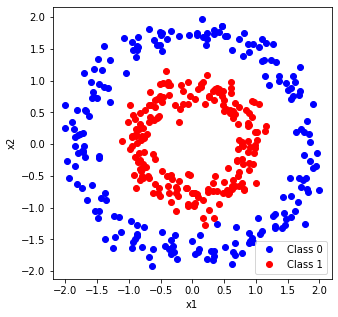

In [2]:
# Import Data and train/test split; plot the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
data_lin_sep_svm = pd.read_csv("./data/kernelized_svm/circles.csv")
X = data_lin_sep_svm.iloc[:,:2]
y = data_lin_sep_svm["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

plt.figure(figsize=(5,5))
plt.plot(X_train_sc[y_train==0,0], X_train_sc[y_train==0,1], "bo", label="Class 0")
plt.plot(X_train_sc[y_train==1,0], X_train_sc[y_train==1,1], "ro", label="Class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In [3]:
# Call and train SVM with rbf kernel
from sklearn.svm import SVC 
rbf_svm = SVC(kernel='rbf', gamma=.5, C=.5)
rbf_svm.fit(X_train_sc, y_train)

SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Let's visualize the estimated decision functions $f(\mathbf{x})$ for the first five test units: 

In [4]:
rbf_svm.decision_function(X_test_sc[:5])

array([-0.47902247,  0.9940158 , -1.2705425 ,  0.89898439,  1.47600071])

...and the corresponding predictions: 

In [5]:
rbf_svm.predict(X_test_sc[:5])

array([0, 1, 0, 1, 1])

Unfortunately, when the `kernel` used is not `linear`, we can't retrieve the model coefficients (as explained also in the function documentation).

In [6]:
# This will give an error: 
# rbf_svm.coef_

However, we can retrieve the support vectors (here we only see the first 5): 

In [7]:
rbf_svm.support_vectors_[:5]

array([[-1.47574798, -0.2118328 ],
       [ 1.71357044,  0.23386059],
       [ 0.89408964, -1.40208169],
       [-0.47869547, -1.38586499],
       [ 0.20742308,  1.55501125]])

Now, let's plot the model's decision boundaries and the margins, highlighting the support vectors. 

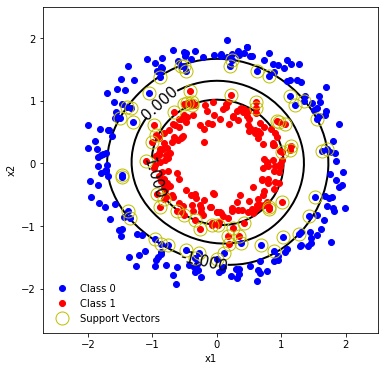

In [8]:
xx, yy = np.meshgrid(np.arange(X_train_sc[:,0].min(), X_train_sc[:,0].max(), 0.1),
                     np.arange(X_train_sc[:,1].min(), X_train_sc[:,1].max(), 0.1))
zz = rbf_svm.decision_function(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6,6))
contour = plt.contour(xx, yy, zz, levels=[-1,0,1], alpha=1., vmin=0, vmax=1, linewidths=2, colors='k', linestyles='-')
plt.clabel(contour, inline=1, fontsize=15, colors='k')
plt.plot(X_train_sc[y_train==0,0], X_train_sc[y_train==0,1], "bo", label="Class 0")
plt.plot(X_train_sc[y_train==1,0], X_train_sc[y_train==1,1], "ro", label="Class 1")
plt.plot(rbf_svm.support_vectors_[:,0], rbf_svm.support_vectors_[:,1], "yo", markerfacecolor='none', markersize=13, 
        label="Support Vectors")
plt.xlabel("x1")
plt.ylabel("x2")
plt.ylim(-2.7,2.5)
plt.xlim(-2.7,2.5)
plt.legend(loc=3,  frameon=False)
plt.show()

Last, let's assess the accuracy of the model on the test set: 

In [9]:
rbf_svm.score(X_test_sc,y_test)

1.0

**Exercises**. Try out different values of the `gamma` hyperparameter, and see how the perofrmance and decision boundaries change. Next, try with `kernel=poly` and different levels of `degree`. Last, try also with `kernel=linear`. In all these cases, manipulate also the regulazitation parameter `C`, and compare results. 

### 6.2 Multiclass case 
We are now just going to have a quick view of the model output in the multiclass case. We will use the `make_blob` function from scikit-learn in order to generate a synthetic dataset. This time we will try SVM with a polynomial kernel of degree 2, and C=1. As you can read from the documentation, multiclass SVC is always estimated with a 'ovo' (one-versus-one) approach (due to computational reasons). 

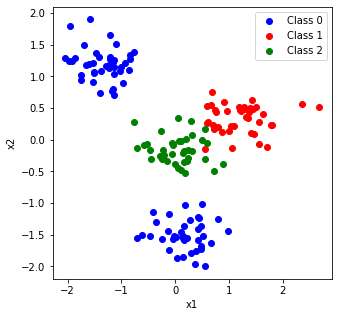

In [10]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, centers=4, cluster_std=1, random_state=2)
y = y % 3
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Draw Data
plt.figure(figsize=(5,5))
plt.plot(X_train_sc[y_train==0,0], X_train_sc[y_train==0,1], "bo", label="Class 0")
plt.plot(X_train_sc[y_train==1,0], X_train_sc[y_train==1,1], "ro", label="Class 1")
plt.plot(X_train_sc[y_train==2,0], X_train_sc[y_train==2,1], "go", label="Class 2")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In [11]:
# Train SVC with polynomial kernel ('ovo' estimation)
poly_svm = SVC(kernel="poly", degree=2, C=1)
poly_svm.fit(X_train_sc, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Let's look at the decision function for the first five test units:

In [12]:
poly_svm.decision_function(X_test_sc[:5])

array([[-0.22011423,  2.2493756 ,  0.8311857 ],
       [ 2.26736387, -0.26452675,  0.94252605],
       [-0.18863002,  0.85422611,  2.22513557],
       [ 2.30595862, -0.28781329,  0.72360872],
       [-0.22491713,  0.92312336,  2.23454846]])

As you can see, decision functions are class-specific. The predictions, as always, can be inspected with the `predict` method: 

In [13]:
poly_svm.predict(X_test_sc[:5])

array([1, 0, 2, 0, 2])

And the test set accuracy: 

In [14]:
poly_svm.score(X_test_sc, y_test)

1.0

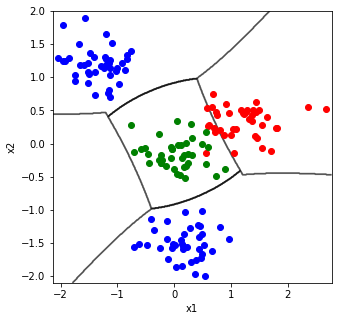

In [15]:
xx, yy = np.meshgrid(
        np.linspace(X_train_sc[:,0].min()-0.1, X_train_sc[:,0].max()+0.1, 500).reshape(-1, 1),
        np.linspace(X_train_sc[:,1].min()-0.1, X_train_sc[:,1].max()+0.1, 500).reshape(-1, 1),
)
zz = poly_svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(5, 5))
plt.contour(xx, yy, zz, alpha=0.25, colors='k')
plt.plot(X_train_sc[y_train==0,0], X_train_sc[y_train==0,1], "bo", label="Class 0")
plt.plot(X_train_sc[y_train==1,0], X_train_sc[y_train==1,1], "ro", label="Class 1")
plt.plot(X_train_sc[y_train==2,0], X_train_sc[y_train==2,1], "go", label="Class 2")

plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

**Exercise**. Try out different values for the polynomial kernel, different values of C, and different kernels. Compare the results. 

## 7. Application to the Heart Dataset 
We are now going to cross-validate several SVM models, with varying kernels, on the Heart data. The goal is to find which is the best combination of kernel+hyperparameter values, in order to discover what type of relationships might be present between the features and the presence/absence of heart disease. 

We will make use of the following grid: 
* RBF kernel, with gamma= 0.01, 0.1, 0.5, 1., 5.
* polynomial kernel, with degree=1, 2, 3, and 10 
* linear kernel
* for all kernels above, C will be set equal to 0.001, 0.01, 0.1, 0.5, 2, and 10.

Validation will be performed with 10-fold-CV. In order to keep track of what GridSearchCV is doing, we will also set the `verbose` parameter. 

In [16]:
# Load datasets
data_train = pd.read_csv("./data/heart_data/heart_train_processed.csv")
data_test = pd.read_csv("./data/heart_data/heart_test_processed.csv")
X_train = data_train.drop("y", axis=1)
X_test = data_test.drop("y", axis=1)
y_train = data_train["y"]
y_test = data_test["y"]

In [17]:
from sklearn.model_selection import GridSearchCV
# Set parameter grid 
C_grid = [1e-3, 1e-2, 1e-1, 5e-1, 2, 10]
tuning_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-2, 1e-1, 5e-1, 1., 5.], 'C': C_grid},
                    {'kernel': ['poly'], 'degree': [1, 2, 3, 10], 'C':C_grid}, 
                    {'kernel': ['linear'], 'C': C_grid}]

# Launch GridSearchCV
clf = GridSearchCV(SVC(), tuning_parameters, cv=10, n_jobs=-1, verbose=2 )
clf.fit(X_train, y_train)
print("CV Grid Search: Done")

Fitting 10 folds for each of 66 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.0s


CV Grid Search: Done


[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:    2.0s finished


The best estimator found with grid search is: 

In [18]:
clf.best_estimator_

SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Which is a polynomial kernel of degree 1: this corresponds to a SVM algorithm with linear kernel (or, equivalently, to a linear SVM algorithm). The best performing model leads to the CV accuracy: 

In [19]:
clf.best_score_

0.8478333333333333

Which is in line, indeed, with what we have observed with the linear models. This can suggest that linear relationships are actually the best suited one to describe the relationships between the predictors in the dataset and the presence/absence of heart disease. Let's compare the performance of the estimated models:  

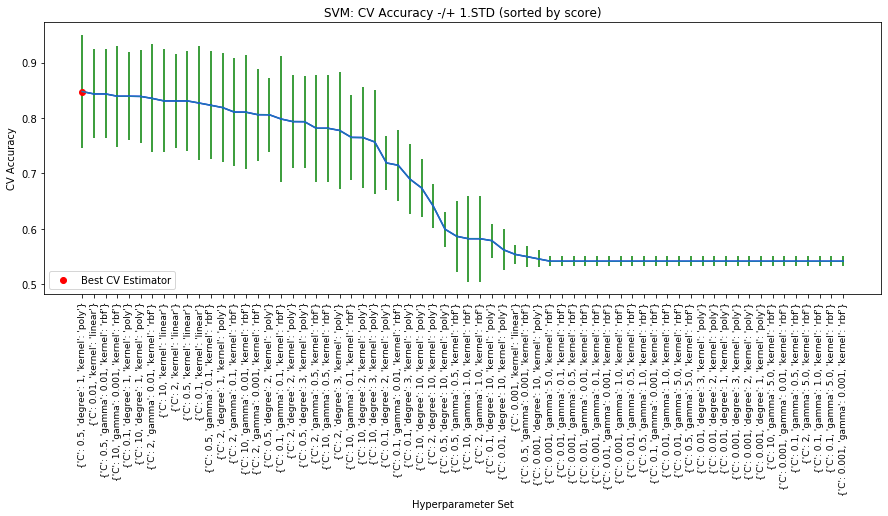

In [20]:
cv_res = pd.DataFrame(clf.cv_results_).sort_values(by="mean_test_score", ascending=False)
plt.figure(figsize=(15,5))
x_ax = np.linspace(0, cv_res.shape[0], cv_res.shape[0])
plt.errorbar(x_ax, cv_res["mean_test_score"], yerr=cv_res["std_test_score"], ecolor='g')
plt.plot(x_ax, cv_res["mean_test_score"], "b-")
plt.plot(np.argmax(cv_res["mean_test_score"].to_numpy()), clf.best_score_, "ro", label="Best CV Estimator")
plt.xticks(x_ax, (cv_res["params"]), rotation=90, fontsize=9)
plt.xlabel("Hyperparameter Set")
plt.ylabel("CV Accuracy")
plt.title("SVM: CV Accuracy -/+ 1.STD (sorted by score)")
plt.legend(loc=3)
plt.show()

We see that the two best performing models are indeed linear models. However, they also have large standard errors in their CV accuracies, which potentially makes SVM algorithms with RBF kernels also good candidates to describe the mechanism that govern the presence/absence of heart disease in the patients of this dataset.

Last, let's check the accuracy of the best performing model on the test set: 

In [21]:
clf.best_estimator_.score(X_test, y_test)

0.8524590163934426